# Find anomaly using transformer

# 1. give tag using model

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from finance_byu import fama_macbeth
import warnings

In [2]:
input_seq_size = 30
output_seq_size = 1

# Hyperparameters
input_dim = input_seq_size * 32  # 特征数量
d_model = 1024
nhead = 64
num_encoder_layers = 3
dim_feedforward = 128
dropout = 0.1
seq_length = 30
batch_size = 32
num_epochs = 10
learning_rate = 0.001

In [3]:
warnings.filterwarnings('ignore')

In [4]:
if torch.cuda.is_available():
    device = torch.device('cuda')  # 选择第一个可用的GPU
else:
    device = torch.device('cpu')  # 若GPU不可用，则选择CPU

In [5]:
class StockDataset(Dataset):
    def __init__(self, features, targets, seq_length=30):
        self.features = features
        self.targets = targets
        self.seq_length = seq_length

    def __len__(self):
        return len(self.features) - self.seq_length

    def __getitem__(self, idx):
        x = self.features[idx:idx + self.seq_length]
        y = self.targets[idx + self.seq_length]
        return x, y


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = nn.Parameter(torch.zeros(1, 500, d_model))  # 500 is a max sequence length
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, src):
        src = self.embedding(src) * np.sqrt(self.d_model)
        src += self.pos_encoder[:, :src.size(1), :]
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

In [6]:
model = TransformerModel(input_dim=input_dim, d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers, dim_feedforward=dim_feedforward)
model.load_state_dict(torch.load('models/new_10_epochs.pth'))
model.to(device)

TransformerModel(
  (embedding): Linear(in_features=960, out_features=1024, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=1024, out_features=1, bias=True)
)

In [7]:
data = pd.read_feather('temp/before1.6_monthly_stock_return.feather')

data['index'] = data.index

# change data type
data['size_tag'] = data['size_tag'].astype('float64')
data['ROE_tag'] = data['ROE_tag'].astype('float64')
data['bm_tag'] = data['bm_tag'].astype('float64')
data['INV_tag'] = data['INV_tag'].astype('float64')
data['momentum_tag'] = data['momentum_tag'].astype('float64')
data['reversal_tag'] = data['reversal_tag'].astype('float64')

feature_list = ['monthly_stock_return', 'rf', 'excess_return',
                'market_value', 'JAN', 'total_assets', 'total_shareholders_equity',
                'BM ratio', 'ROE', 'assets_increasing_rate', 'momentum', 'reversal',
                'size_tag', 'ROE_tag', 'bm_tag', 'INV_tag', 'momentum_tag',
                'reversal_tag', 'mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA',
                't+1_excess_return', 'JAN t+1', 'size*JAN', 'BM*JAN',
                'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN',
                'mkt_risk_premium*JAN']
scaler = StandardScaler()
mean_list = []
std_list = []
data[feature_list] = scaler.fit_transform(data[feature_list])
normalized_data = data
normalized_mean = scaler.mean_
normalized_std = scaler.scale_

In [8]:
def get_src(data, num_samples, input_seq_size):
    if len(data) - input_seq_size - output_seq_size + 1 <= 0:
        return
    src_data = np.array([data[i:i + input_seq_size] for i in range(num_samples)])
    return src_data


def get_tgt(data, num_samples, input_seq_size, output_seq_size):
    if len(data) - input_seq_size - output_seq_size + 1 <= 0:
        return
    tgt_data = np.array([data['monthly_stock_return'][i + input_seq_size:i + input_seq_size + output_seq_size] for i in range(num_samples)])
    return tgt_data

In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# normalized_data = normalized_data[(normalized_data['Stkcd'] == "000001") | (normalized_data['Stkcd'] == "000002")]

# test_data = normalized_data[normalized_data['month'] >= '2013-03-01']
test_data = normalized_data

test_data['new_factor'] = 0
test_data['new_factor'] = test_data['new_factor'].astype('float64')

src_data = test_data.groupby('Stkcd', observed=False).apply(
    lambda x: get_src(x[feature_list + ['index',]], len(x) - input_seq_size - output_seq_size + 1, input_seq_size), include_groups=False)
src_data.dropna(inplace=True)
src_data = np.concatenate(src_data)
src_data = src_data.reshape(src_data.shape[0], input_dim + input_seq_size)  # containing 30 index
src_data = torch.tensor(src_data).float().to(device)

tgt_data = test_data.groupby('Stkcd', observed=False).apply(
    lambda x: get_tgt(x[feature_list], len(x) - input_seq_size - output_seq_size + 1, input_seq_size, output_seq_size), include_groups=False)
tgt_data.dropna(inplace=True)
tgt_data = np.concatenate(tgt_data)
# tgt_data = tgt_data.reshape(tgt_data.shape[0], 32)
tgt_data = torch.tensor(tgt_data).float().to(device)

# Create DataLoader
dataset = StockDataset(src_data, tgt_data, seq_length=input_seq_size)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

model.eval()

TransformerModel(
  (embedding): Linear(in_features=960, out_features=1024, bias=True)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=1024, out_features=1, bias=True)
)

In [11]:
index_list = []
with torch.no_grad():
    total_loss = 0
    for batch in dataloader:
        x_batch, y_batch = batch
        y_batch = y_batch.float()
        index = int(x_batch[0][-1][-1])
        index_list.append(index)
        tmp = torch.zeros(1, input_seq_size, input_dim)
        for i in range(len(x_batch[0])):
            tmp[0][i] = torch.cat([x_batch[0][i][i*33:i*33+32] for i in range(input_seq_size)])
        tmp = tmp.to(device)

        output = model(tmp)
        
        result = float(output.squeeze())
        test_data.loc[index, 'new_factor'] = result
        
        loss = criterion(output.squeeze(), y_batch)
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    print(f"Loss on Test set: {avg_loss:.4f}")

Loss on Test set: 1.1785


In [12]:
# result, index
min(index_list)

58

In [13]:
test_data = test_data[test_data['index'].isin(index_list)]
test_data[['Stkcd', 'month', 'new_factor', 'monthly_stock_return', 'index']]

,Stkcd,month,new_factor,monthly_stock_return,index
58,000001,2005-10,-0.083466,-0.132384,58
59,000001,2005-11,-0.177387,0.072326,59
60,000001,2005-12,0.001390,0.258480,60
61,000001,2006-01,-0.198817,0.146743,61
62,000001,2006-02,-0.510792,0.426388,62
...,...,...,...,...,...
663815,900957,2023-05,0.568868,-0.274241,663815
663816,900957,2023-06,0.187155,-0.293254,663816
663817,900957,2023-07,-0.399006,0.188710,663817
663818,900957,2023-08,0.335511,-1.118303,663818


# 2. find anomaly

## 2.1 Fama-MacBeth regression

In [14]:
test_data.head()

,Stkcd,month,monthly_stock_return,rf,excess_return,market_value,total_assets,total_shareholders_equity,BM ratio,ROE,...,JAN t+1,size*JAN,BM*JAN,ROE*JAN,INV*JAN,MOM*JAN,REV*JAN,mkt_risk_premium*JAN,index,new_factor
58,000001,2005-10,-0.132384,0.287363,-0.145755,-0.035252,3.285606,-0.797119,-0.209182,0.008026,...,-0.296715,0.066841,-0.047263,-0.004232,-0.001874,-0.216494,-0.038755,-0.069897,58,-0.083466
59,000001,2005-11,0.072326,0.287363,0.058828,-0.030581,3.285606,-0.797119,-0.209553,0.008026,...,-0.296715,0.066841,-0.047263,-0.004232,-0.001874,-0.216494,-0.038755,-0.069897,59,-0.177387
60,000001,2005-12,0.258480,0.287363,0.244866,-0.019802,3.434135,-0.793254,-0.210263,0.007411,...,3.370240,-3.151475,0.924403,0.069667,0.020144,2.421625,-1.007881,2.879359,60,0.001390
61,000001,2006-01,0.146743,0.287363,0.133199,-0.012256,3.316484,-0.791689,-0.210745,0.005891,...,-0.296715,0.066841,-0.047263,-0.004232,-0.001874,-0.216494,-0.038755,-0.069897,61,-0.198817
62,000001,2006-02,0.426388,0.287363,0.412670,0.005350,3.316484,-0.791689,-0.211828,0.005891,...,-0.296715,0.066841,-0.047263,-0.004232,-0.001874,-0.216494,-0.038755,-0.069897,62,-0.510792


In the first step, we run the cross-sectional regression:
$$EXRET_{i,t+1}=\beta_{0,t}+\beta_{1,t}SIZE_{t}+\beta_{2,t}SIZE_{t}*JAN_{t+1}+\beta_{3,t}BM_{t}+\beta_{4,t}BM_{t}*JAN_{t+1}+\beta_{5,t}ROE_{t}+\beta_{6,t}ROE_{t}*JAN_{t+1}+\beta_{7,t}INV_{t}+\\ \beta_{8,t}INV_{t}*JAN_{t+1}+\beta_{9,t}MOM_{t}+\beta_{10,t}MOM_{t}*JAN_{t+1}+\beta_{11,t}REV_{t}+\beta_{12,t}REV_{t}*JAN_{t+1}+\beta_{13,t}MRKRP_{t}+\beta_{14,t}MKTRP_{t}*JAN_{t+1}+\beta_{15,t}new\_factor_{t}+e_{i,t+1}$$

Then we can get the time-series average of the coefficients:
$$\bar{\beta_i}=\frac{1}{T}\sum_{t=1}^{T}\beta_{i,t}$$

Also, we can get  Standard errors, t-statistics, and p-values calculated using the Newey and West (1987) adjustment with six lags.

In [15]:
test_data.dtypes

Stkcd                           object
month                        period[M]
monthly_stock_return           float64
rf                             float64
excess_return                  float64
market_value                   float64
total_assets                   float64
total_shareholders_equity      float64
BM ratio                       float64
ROE                            float64
assets_increasing_rate         float64
momentum                       float64
reversal                       float64
size_tag                       float64
ROE_tag                        float64
bm_tag                         float64
INV_tag                        float64
momentum_tag                   float64
reversal_tag                   float64
mkt_risk_premium               float64
SMB                            float64
HML                            float64
RMW                            float64
CMA                            float64
t+1_excess_return              float64
JAN                      

In [16]:
test_data[feature_list] = (test_data[feature_list] + normalized_mean) * normalized_std

In [17]:
factors_list = ['month','t+1_excess_return', 'SMB', 'HML', 'RMW', 'CMA', 'momentum', 'reversal', 'mkt_risk_premium', 'size*JAN', 'BM*JAN', 'ROE*JAN', 'INV*JAN', 'MOM*JAN', 'REV*JAN', 'mkt_risk_premium*JAN', 'new_factor']

In [18]:
my_fm = fama_macbeth.fama_macbeth(test_data.loc[:,factors_list].dropna(), 'month', 't+1_excess_return', factors_list[2:])
result_my_fm = fama_macbeth.fm_summary(my_fm, pvalues=True)
result_my_fm

,mean,std_error,tstat,pval
intercept,0.005049,0.007760,0.650580,5.159270e-01
SMB,-0.000411,0.000552,-0.745538,4.566614e-01
HML,-0.000031,0.000338,-0.091595,9.270945e-01
RMW,0.000010,0.000322,0.031854,9.746145e-01
CMA,0.000111,0.000220,0.505536,6.136372e-01
momentum,0.002433,0.001130,2.153570,3.224998e-02
reversal,0.001814,0.000995,1.822423,6.960973e-02
mkt_risk_premium,0.002276,0.000915,2.486140,1.358111e-02
size*JAN,-0.039604,0.051900,-0.763083,4.461482e-01
BM*JAN,0.031520,0.057561,0.547590,5.844717e-01


## 2.2 Anomaly detection

In [19]:
# test_data[test_data['new_factor'] == 0]['new_factor'] = -1
# test_data[test_data['new_factor'] == -1]['new_factor'] = 0

In [20]:
long_short = test_data.groupby(['month'], observed=False).apply(lambda x: np.average(x['excess_return'], weights=x['new_factor']))

In [21]:
long_short = long_short.to_frame()
long_short.columns = ['new_factor']

In [22]:
# import and clean the risk-free rate data
rf = pd.read_excel('source_data/Risk-Free Rate/TRD_Nrrate.xlsx')  # load the risk-free rate data
rf = rf.iloc[2:, :]
rf = rf[['Clsdt', 'Nrrdaydt','Nrrdata']]
rf.columns = ['date', 'daily_rf','rf']
rf['date'] = pd.to_datetime(rf['date'])
rf['daily_rf'] = rf['daily_rf'] / 100  # change the unit of the risk-free rate to decimal
rf['rf'] = rf['rf'] / 100  # change the unit of the risk-free rate to decimal
rf['month'] = rf['date'].dt.to_period('M')
rf_monthly = rf.groupby('month').agg({'daily_rf': [lambda x: (1 + x).prod() - 1], 'rf': 'last'})
rf_monthly.reset_index(inplace=True)
rf_monthly.columns = ['month', 'monthly_rf','rf']

In [23]:
# load fama-french five factors data
factor_data = pd.read_excel(
    'source_data/5-Factor Model Index (Monthly)/STK_MKT_FIVEFACMONTH.xlsx')
factor_data = factor_data[
    ['MarkettypeID', 'TradingMonth', 'Portfolios', 'RiskPremium2', 'SMB2', 'HML2', 'RMW2', 'CMA2']]
factor_data.columns = ['MarkettypeID', 'date', 'portfolios', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']
factor_data = factor_data.iloc[2:, :]
factor_data = factor_data[factor_data['portfolios'] == 1]
factor_data = factor_data[
    factor_data['MarkettypeID'] == "P9706"]  # P9706: SSE-SZSE A share market (excluding STAR Market, ChiNext)
factor_data.reset_index(drop=True, inplace=True)  # reset the index to 0,1,2,...
factor_data = factor_data[['date', 'risk_premium', 'smb', 'hml', 'rmw', 'cma']]
factor_data.columns = ['month', 'mkt_risk_premium', 'SMB', 'HML', 'RMW', 'CMA']
factor_data['month'] = pd.to_datetime(factor_data['month']).dt.to_period('M')

In [24]:
long_short['month'] = long_short.index

# merge rf and market return to long_short and long_short
long_short['rf'] = long_short['month'].map(rf_monthly.set_index('month')['monthly_rf'])
long_short['mkt_risk_premium'] = long_short['month'].map(factor_data.set_index('month')['mkt_risk_premium'])
long_short['market_return'] = long_short['mkt_risk_premium'] + long_short['rf']
long_short['new_factor'] = long_short['new_factor'] + long_short['rf']

long_short.head()

,new_factor,month,rf,mkt_risk_premium,market_return
month,,,,,
2003-05,0.068604,2003-05,0.001675,0.040669,0.042344
2003-06,-0.062721,2003-06,0.001621,-0.059786,-0.058165
2003-07,-0.041765,2003-07,0.001675,-0.011581,-0.009906
2003-08,-0.035821,2003-08,0.001675,-0.035328,-0.033653
2003-09,-0.066269,2003-09,0.001621,-0.043523,-0.041902


In [25]:
# long_short['new_factor'] = long_short['new_factor'] - long_short['rf']

In [26]:
long_short['temp'] = long_short['new_factor'].apply(lambda x: x if x >=-.1 else -0.1)

<Axes: xlabel='month'>

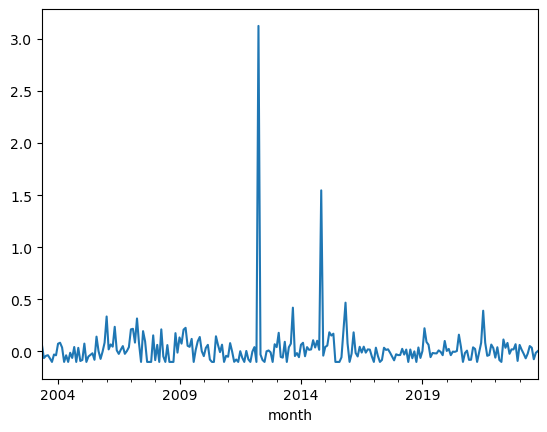

In [27]:
# np.prod(long_short['temp'] + 1) - 1
long_short['temp'].plot()
# (long_short['temp']+1).cumprod().plot()

# np.prod(long_short['new_factor'] + 1) - 1
# long_short['new_factor'].plot()